* **TODO:** Fix ANC wordlist to only include lemmas
* **TODO:** Expand ANC wordlist to include uncommon words in `[word for word in essay_words if word not in anc_words]`
* **TODO:** LASSO on word vector components?

In [4]:
# Data-handling imports
import pandas as pd
import numpy as np

# Text-handling imports
import spacy

# Other imports
from progress import show_progress
import matplotlib.pyplot as plt

# Options
freq_col = "freq_per_100000"

# Read in data

## Essays

In [5]:
# Read in essay and score data
essays = pd.read_csv("../data_private/train.tsv", sep="\t")

## NLP data

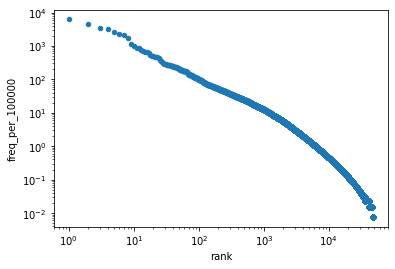

In [6]:
# Read in American English word frequency list
freqs = pd.read_csv("../data/anc_frequency_list.csv")

# Merge homonyms, as they won't affect the analysis much
freqs = pd.DataFrame(freqs.groupby("lemma")[freq_col].sum())

# Add rank
freqs["rank"] = freqs[freq_col].rank(method="min", ascending=False).astype(int)

# Demonstrate Zipf's Law on the frequency list as a sanity check
freqs.plot.scatter("rank", freq_col, loglog=True);

In [7]:
# Initialize spaCy
nlp = spacy.load('en')

# Define metrics

In [9]:
def freq_score(doc):
    """Calculates an arbitrarily-defined "frequency metric"
    that tries to capture how many infrequent words are used
    in the text."""
    l = []
    score = 0
    known_words = 0
    for word in doc:
        lemma = word.lemma_
        try:
            score += (freqs.loc[lemma, "rank"])
            l.append((lemma, freqs.loc[lemma, "rank"]))
            known_words += 1
        except KeyError:
            pass
    return np.log(score/known_words)

def freq_graph(doc):
    """Calculates an arbitrarily-defined "frequency metric"
    that tries to capture how many infrequent words are used
    in the text."""
    lemmas = set([word.lemma_ for word in doc if word.lemma_ in freqs.index])
    plt.figure()
    plt.xscale("log")
    plt.yscale("log")
    plt.xlim(freqs["rank"].min(), freqs["rank"].max())
    plt.scatter("rank", freq_col, data=freqs.loc[lemmas, :], color="red");
    plt.text(x=freqs.loc[lemmas, :]["rank"], y=freqs.loc[lemmas, :][freq_col], s=lemmas)
    
# Demonstrate "frequency metric" on some sample sentences
sents = [
    "I am he as you are he as you are me and we are all together.",
    "We shall fight on the beaches.",
    "The cat sat on the mat.",
    "The boy stood on the burning deck whence all but he had fled.",
    "In a hole in the ground, there lived a hobbit.",
    "'Twas brillig, and the slithy toves did gyre and gimble in the wabe."
]

# for sent in sents:
#     s = nlp(sent)
#     print(freq_score(s))
#     freq_graph(s)

4.216234379831137
6.50757617530321
7.496837400713895
7.59316426344696
8.400412153592317
9.58948203841483


TypeError: cannot convert the series to <class 'float'>

<Figure size 432x288 with 1 Axes>

TypeError: cannot convert the series to <class 'float'>

<Figure size 432x288 with 1 Axes>

TypeError: cannot convert the series to <class 'float'>

<Figure size 432x288 with 1 Axes>

TypeError: cannot convert the series to <class 'float'>

<Figure size 432x288 with 1 Axes>

TypeError: cannot convert the series to <class 'float'>

<Figure size 432x288 with 1 Axes>

TypeError: cannot convert the series to <class 'float'>

<Figure size 432x288 with 1 Axes>

In [11]:
def tf_idf(i, j):
    """Calculates tf-idf score for each word in the
    FIRST corpus passed."""
    tf = i / (i + j)
    
    i_count = (i != 0).astype(int)
    j_count = (j != 0).astype(int)
    idf = np.log((i_count + j_count) / i_count)
    
    return df * idf

The tf-idf is a widely-used metric for showing the distribution of a word type between corpora; however, it's a bit austere in assigning a value of 0 to any word type which occurs in both corpora. Here we prefer the log-odds with uninformative Dirichlet prior (Monroe et al. 2008), which weighs the odds ratio of the word's appearance in each distribution against the prior probability of its appearing in *either* distribution. This model has the downside that a word appearing in only one corpus has infinite (or negatively infinite) log odds—we deal with this by adding one to each observation, per Laplace's [Rule of Succession](https://en.wikipedia.org/wiki/Rule_of_succession).

In [12]:
def logodds_dirichlet(i, j, prior=None):
    """Calculate log-odds, uninformative Dirichlet prior
    (Monroe et al. 2008, sec. 3.3.4). The higher a word's
    value, the more "representative" it is of corpus i.
    A values of zero means no preference between corpora."""

    # Add one to each observation, per Laplace's Rule of
    # Succession, so we don't end up dividing by zero.
    i += 1
    j += 1
    
    if prior is None:
        prior = i + j
    
    # Compute word frequency totals
    n_i     = np.sum(i)
    n_j     = np.sum(j)
    n_prior = np.sum(prior) # α_0

    # Compute the prior log odds
    delta = np.log((i + prior) / (n_i + n_prior - i - prior)) - \
            np.log((j + prior) / (n_j + n_prior - j - prior))

    # Compute the standard deviation
    sigma = np.sqrt(1/(i + prior) + 1/(j + prior))

    # Convert to z-score
    return delta / sigma

# Compute metrics

In [13]:
doc = nlp(essays.loc[0, "essay"])
doc = nlp("I think; therefore, I am.")


len(set(map(lambda x: x.text, doc)))

7

In [14]:
def is_word(w):
    return (not w.is_space) and (not w.is_punct)


@show_progress
def parse_essays(i, essay):
    # Compute various metrics:
    doc = nlp(essay)

    # Token count
    essays.loc[i, "tokens"] = len(list(filter(is_word, doc)))

    # Type count (may be inflated by misspellings)
    essays.loc[i, "types"] = len(set([word.lemma_ for word in doc if not word.is_punct and not word.is_space]))
    
    # Mean sentence length
    essays.loc[i, "sent_len"] = np.mean([len(list(filter(is_word, s))) for s in doc.sents])
    
    # Mean word length
    essays.loc[i, "word_len"] = np.mean(list(map(len, filter(is_word, doc))))

    # Semicolons
    essays.loc[i, "semicolons"] = len([token for token in doc if token.text == ";"])

In [15]:
parse_essays(essays["essay"])

Done! Parsed 12976 items in 14:04.


# Compute scores

In [18]:
# If only one score exists, use that. Otherwise, take the mean of both scores.
essays["score"] = map(np.nanmean, zip(essays["domain1_score"], essays["domain2_score"]))

# Write out

In [19]:
essays.to_csv("../data_private/essays_cleaned.csv", index=False)

# References

Monroe, Burt L., Michael P. Colaresi, and Kevin M. Quinn. 2008. “Fightin’ Words: Lexical Feature Selection and Evaluation for Identifying the Content of Political Conflict.” *Political Analysis* 16 (4): 372–403. doi:[10.1093/pan/mpn018](https://doi.org/10.1093/pan/mpn018).